In [23]:
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import RobustScaler
import optuna
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
import joblib

In [24]:
df = pd.read_csv('../dataset.csv')

**Preprocessing**

*Analize the distribution of the continous columns*


Distribution Statistics:

age:
Skewness: 0.558
Kurtosis: -0.184

capital-gain:
Skewness: 5.866
Kurtosis: 42.918

capital-loss:
Skewness: 4.570
Kurtosis: 20.012

hours-per-week:
Skewness: 0.239
Kurtosis: 2.951


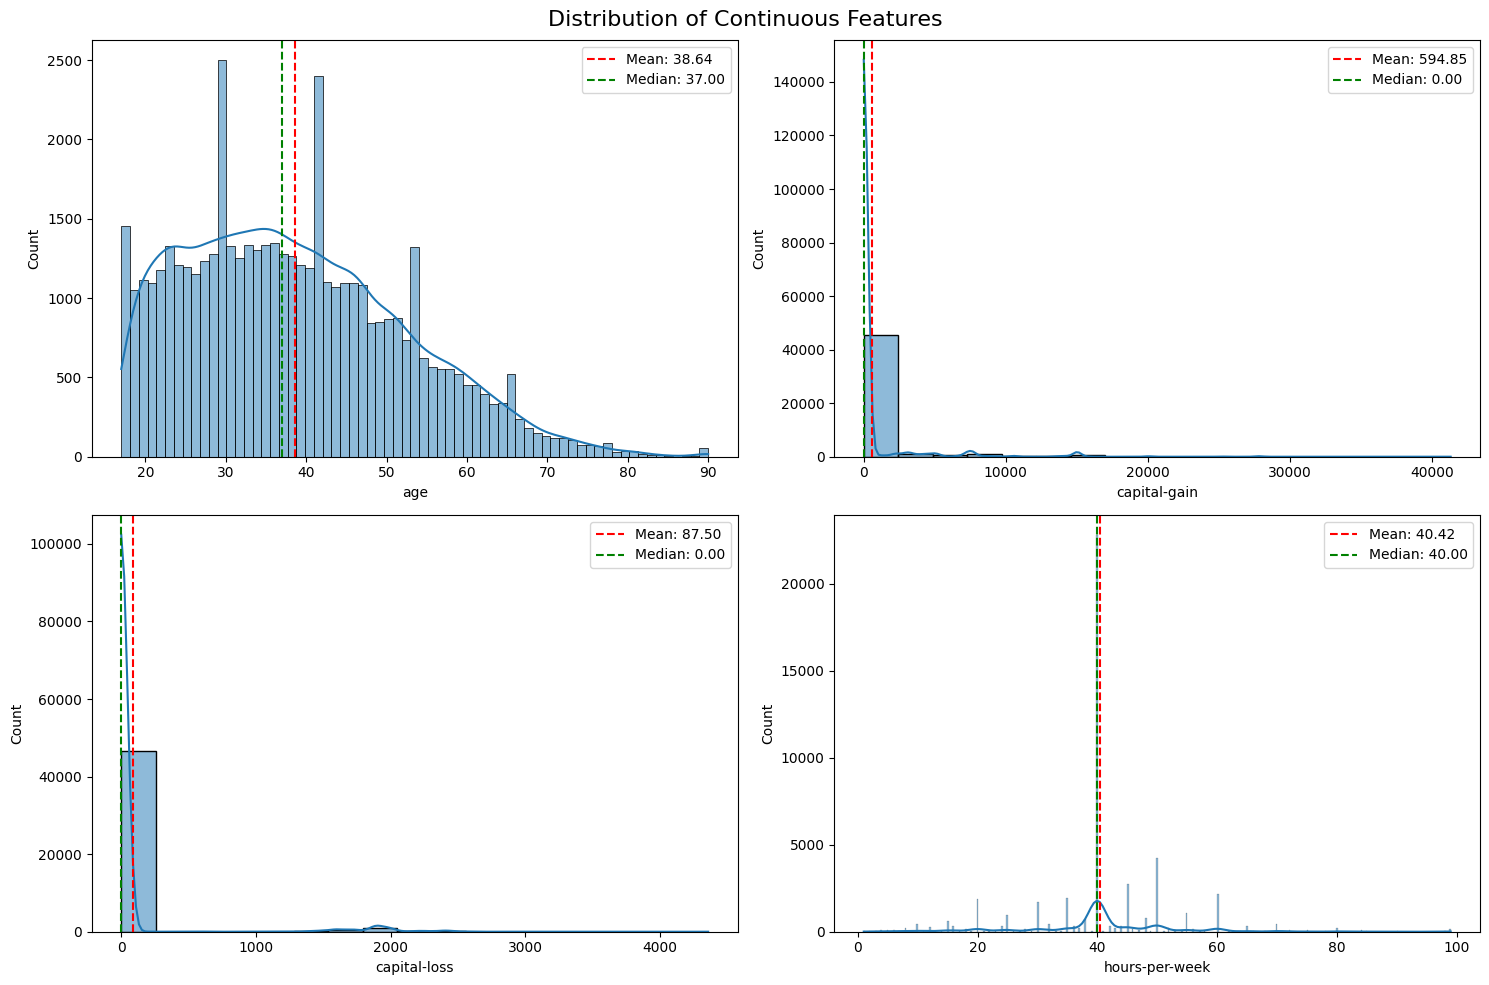

In [25]:

continuous_cols = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

# Create subplots for distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Continuous Features', fontsize=16)

# Plot distribution for each continuous variable
for idx, col in enumerate(continuous_cols):
    ax = axes[idx//2, idx%2]
    
    # Plot histogram and kernel density estimate
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    
    # Add basic statistics
    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
    ax.legend()
    
plt.tight_layout()

# Print skewness and kurtosis
print("\nDistribution Statistics:")
for col in continuous_cols:
    print(f"\n{col}:")
    print(f"Skewness: {stats.skew(df[col]):.3f}")
    print(f"Kurtosis: {stats.kurtosis(df[col]):.3f}")



*Change the Scale of capital-gain and capital-loss and apply robust scaling to all the features*

Considering the distribution of the continuous features (in particular capital-gain and capital-loss), log(1+x) transformation is required. This is done for reducing the extreme values while preserving the relative differences. Considering that HDBSCAN works with distance-based density estimation, extreme values can dominate distance calculations. 

After that, apply RobustScaler so that the features are brought to comparable scales and distances calculations become more meaningful.


In [26]:
df_transformed = df.copy()

# Log1p transformation for financial features
df_transformed['capital-gain'] = np.log1p(df_transformed['capital-gain'])
df_transformed['capital-loss'] = np.log1p(df_transformed['capital-loss'])

# Apply RobustScaler to all numerical features
numerical_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = RobustScaler()
df_transformed[numerical_features] = scaler.fit_transform(df_transformed[numerical_features])

#joblib.dump(scaler, "robust_scaler.pkl")


## Uncomment this to plot the distributions after the transformations
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# fig.suptitle('Distribution Before and After Transformation', fontsize=16)

# for idx, col in enumerate(['capital-gain', 'capital-loss']):
#     # Original distribution
#     sns.histplot(data=df, x=col, kde=True, ax=axes[idx, 0])
#     axes[idx, 0].set_title(f'Original {col}')
    
#     # Transformed distribution
#     sns.histplot(data=df_transformed, x=col, kde=True, ax=axes[idx, 1])
#     axes[idx, 1].set_title(f'Transformed {col}')

# plt.tight_layout()

In [27]:
#Save the labels and drop them for clustering
X = df_transformed.drop('income', axis=1)  # Features (all columns except 'income')
true_labels = df['income'].values  # True labels from 'income' column

**Finding the best set of hyperparameters for HDBSCAN**

Need to prioritize cluster purity, in particular Pattern Discovery (Silhouette score). Using Optuna for finding the best hyperparameters

In [6]:
def objective(trial, X, true_labels):
    """
    Optuna objective function for optimizing HDBSCAN parameters
    """
    # Define the parameter search space
    min_cluster_size = trial.suggest_int('min_cluster_size', 50, 500)
    min_samples = trial.suggest_int('min_samples', max(5, min_cluster_size//10), min_cluster_size)
    cluster_selection_epsilon = trial.suggest_float('cluster_selection_epsilon', 0.0, 1.0)
    
    # Initialize HDBSCAN with trial parameters
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True
    )
    
    # Fit and predict
    cluster_labels = clusterer.fit_predict(X)
    
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    
    # If only one cluster or all points are noise, return worst possible score
    if n_clusters <= 1:
        return -float('inf')
    
    # Calculate silhouette score for non-noise points
    non_noise_mask = cluster_labels != -1
    if non_noise_mask.sum() > 1:
        sil_score = silhouette_score(X[non_noise_mask], cluster_labels[non_noise_mask])
    else:
        sil_score = -float('inf')
    
    # Calculate other metrics
    ari_score = adjusted_rand_score(true_labels, cluster_labels)
    nmi_score = normalized_mutual_info_score(true_labels, cluster_labels)
    noise_ratio = (cluster_labels == -1).sum() / len(cluster_labels)
    
    # Objective score (weights)
    objective_score = (
        0.4 * sil_score +      # Weight for cluster quality
        0.3 * ari_score +      # Weight for agreement with true labels
        0.2 * nmi_score -      # Weight for information shared with true labels
        0.1 * noise_ratio      # Small penalty for excessive noise
    )
    
    # Store additional metrics for analysis
    trial.set_user_attr('n_clusters', n_clusters)
    trial.set_user_attr('silhouette', sil_score)
    trial.set_user_attr('ari', ari_score)
    trial.set_user_attr('nmi', nmi_score)
    trial.set_user_attr('noise_ratio', noise_ratio)
    
    return objective_score

def optimize_hdbscan(X, true_labels, n_trials=100):
    """
    Run Optuna optimization for HDBSCAN parameters
    """
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, true_labels), n_trials=n_trials)
    
    # Get best parameters
    best_params = study.best_trial.params
    
    # Print optimization results
    print("\nOptimization Results:")
    print("Best parameters:", best_params)
    print("Best trial metrics:")
    print(f"Number of clusters: {study.best_trial.user_attrs['n_clusters']}")
    print(f"Silhouette score: {study.best_trial.user_attrs['silhouette']:.3f}")
    print(f"Adjusted Rand Index: {study.best_trial.user_attrs['ari']:.3f}")
    print(f"NMI score: {study.best_trial.user_attrs['nmi']:.3f}")
    print(f"Noise ratio: {study.best_trial.user_attrs['noise_ratio']:.3f}")
    
    return best_params, study

# Usage:
best_params, study = optimize_hdbscan(X, true_labels, n_trials=100)

[I 2025-01-14 21:15:19,333] A new study created in memory with name: no-name-6d261cf5-74e8-409f-952e-ece9b0a2097f
[W 2025-01-14 21:15:23,648] Trial 0 failed with parameters: {'min_cluster_size': 77, 'min_samples': 24, 'cluster_selection_epsilon': 0.6641756233308204} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/andrea-gariboldi/Master/Year1/Semester1/AppliedMachineLearning/ICS5110-Applied_ML/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_22590/4269941946.py", line 63, in <lambda>
    study.optimize(lambda trial: objective(trial, X, true_labels), n_trials=n_trials)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_22590/4269941946.py", line 32, in objective
    sil_score = silhouette_score(X[non_noise_mask], cluster_labels[non_noise_mask])
                ^^^^^^^^^

KeyboardInterrupt: 

**Model training**

Once found the best set of hyperparameters, create the model using them. Then evaluate the result obtained by the model

In [28]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=220,
    min_samples=117,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
    cluster_selection_epsilon=0.28479667859306007
)

cluster_labels = clusterer.fit_predict(X)

**Basic metrics**

In [29]:
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

non_noise_mask = cluster_labels != -1
sil_score = silhouette_score(X[non_noise_mask], cluster_labels[non_noise_mask])


ari_score = adjusted_rand_score(true_labels, cluster_labels)
nmi_score = normalized_mutual_info_score(true_labels, cluster_labels)
noise_ratio = (cluster_labels == -1).sum() / len(cluster_labels)

print(f"Number of clusters: {n_clusters}")
print(f"Silhouette score: {sil_score}")
print(f"Adjusted Rand Index: {ari_score}")
print(f"NMI score: {nmi_score}")
print(f"Noise ratio: {noise_ratio}")



Number of clusters: 3
Silhouette score: 0.4832029784130048
Adjusted Rand Index: 0.19673971019979436
NMI score: 0.07800923172641949
Noise ratio: 0.003419188403423283


**Analyze intra-cluster distributions and characteristics**

In [30]:
def analyze_cluster_distributions(df_transformed, cluster_labels):
    """
    Analyze the distribution of features within each cluster using transformed data
    Including PCA components from workclass and occupation
    """
    # Add cluster labels to the dataframe
    df_with_clusters = df_transformed.copy()
    df_with_clusters['Cluster'] = cluster_labels
    
    # Define feature groups
    base_numerical_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
    pca_features = [f'pca_component_{i+1}' for i in range(10)]  # PCA components
    all_numerical_features = base_numerical_features + pca_features
    
    categorical_features = [col for col in df_transformed.columns 
                          if col not in all_numerical_features + ['Cluster', 'income']]
    
    # Create summary statistics for each cluster
    summary_stats = []
    for cluster in sorted(set(cluster_labels)):
        cluster_name = "Noise" if cluster == -1 else f"Cluster {cluster}"
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
        
        cluster_stats = {}
        
        # Analyze base numerical features
        for feature in base_numerical_features:
            stats_dict = {
                'mean': cluster_data[feature].mean(),
                'median': cluster_data[feature].median(),
                'std': cluster_data[feature].std(),
                'min': cluster_data[feature].min(),
                'max': cluster_data[feature].max(),
                'q1': cluster_data[feature].quantile(0.25),
                'q3': cluster_data[feature].quantile(0.75)
            }
            cluster_stats[feature] = stats_dict
        
        # Analyze PCA components
        for feature in pca_features:
            stats_dict = {
                'mean': cluster_data[feature].mean(),
                'median': cluster_data[feature].median(),
                'std': cluster_data[feature].std(),
                'min': cluster_data[feature].min(),
                'max': cluster_data[feature].max(),
                'q1': cluster_data[feature].quantile(0.25),
                'q3': cluster_data[feature].quantile(0.75)
            }
            cluster_stats[feature] = stats_dict
            
        # Analyze remaining categorical features
        for feature in categorical_features:
            value_counts = cluster_data[feature].value_counts(normalize=True).nlargest(3)
            cluster_stats[f'top_{feature}'] = value_counts.to_dict()
        
        summary_stats.append({
            'cluster': cluster_name,
            'size': len(cluster_data),
            'stats': cluster_stats
        })
    
    return summary_stats

def plot_feature_distributions(df_transformed, cluster_labels, feature):
    """
    Plot the distribution of transformed features across different clusters
    """
    plt.figure(figsize=(12, 6))
    for cluster in sorted(set(cluster_labels)):
        label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
        cluster_data = df_transformed[cluster_labels == cluster][feature]
        sns.kdeplot(data=cluster_data, label=label)
    
    title = f'Distribution of {feature}'
    if feature.startswith('PC'):
        title += ' (PCA component from workclass/occupation)'
    else:
        title += ' (transformed)'
    
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def print_cluster_profiles(summary_stats):
    """
    Print detailed profiles for each cluster
    """
    for cluster_info in summary_stats:
        print(f"\n{'-'*50}")
        print(f"{cluster_info['cluster']} (Size: {cluster_info['size']})")
        print(f"{'-'*50}")
        
        stats = cluster_info['stats']
        
        # Print base numerical features statistics
        print("\nBase Numerical Features (Transformed):")
        for feature in ['age', 'capital-gain', 'capital-loss', 'hours-per-week']:
            print(f"\n{feature}:")
            feature_stats = stats[feature]
            print(f"  Mean: {feature_stats['mean']:.3f}")
            print(f"  Median: {feature_stats['median']:.3f}")
            print(f"  Std: {feature_stats['std']:.3f}")
            print(f"  IQR: [{feature_stats['q1']:.3f} - {feature_stats['q3']:.3f}]")
            print(f"  Range: [{feature_stats['min']:.3f} - {feature_stats['max']:.3f}]")
        
        # Print PCA components statistics
        print("\nPCA Components (workclass/occupation):")
        for i in range(10):
            feature = f'pca_component_{i+1}'
            print(f"\n{feature}:")
            feature_stats = stats[feature]
            print(f"  Mean: {feature_stats['mean']:.3f}")
            print(f"  Median: {feature_stats['median']:.3f}")
            print(f"  Std: {feature_stats['std']:.3f}")
            print(f"  IQR: [{feature_stats['q1']:.3f} - {feature_stats['q3']:.3f}]")
        
        # Print categorical features statistics
        if any(key.startswith('top_') for key in stats):
            print("\nCategorical Features:")
            for key in stats:
                if key.startswith('top_'):
                    feature = key.split('_', 1)[1]
                    print(f"\n{feature}:")
                    for category, percentage in stats[key].items():
                        print(f"  {category}: {percentage:.1%}")

# Usage:
summary_stats = analyze_cluster_distributions(df, cluster_labels)
print_cluster_profiles(summary_stats)
# 
#Plot base features
# for feature in ['age', 'capital-gain', 'capital-loss', 'hours-per-week']:
#     plot_feature_distributions(df, cluster_labels, feature)
#
# # Plot PCA components
# for i in range(10):
#     plot_feature_distributions(df_transformed, f'PC{i+1}_work_occ', cluster_labels)


--------------------------------------------------
Noise (Size: 167)
--------------------------------------------------

Base Numerical Features (Transformed):

age:
  Mean: 50.162
  Median: 49.000
  Std: 17.609
  IQR: [37.000 - 66.000]
  Range: [17.000 - 90.000]

capital-gain:
  Mean: 3223.825
  Median: 114.000
  Std: 6449.257
  IQR: [0.000 - 3942.000]
  Range: [0.000 - 41310.000]

capital-loss:
  Mean: 592.054
  Median: 0.000
  Std: 936.242
  IQR: [0.000 - 1658.000]
  Range: [0.000 - 3175.000]

hours-per-week:
  Mean: 57.617
  Median: 72.000
  Std: 39.781
  IQR: [12.000 - 99.000]
  Range: [1.000 - 99.000]

PCA Components (workclass/occupation):

pca_component_1:
  Mean: -0.244
  Median: 0.084
  Std: 0.575
  IQR: [-0.849 - 0.302]

pca_component_2:
  Mean: -0.027
  Median: 0.000
  Std: 0.405
  IQR: [-0.270 - 0.114]

pca_component_3:
  Mean: 0.024
  Median: -0.020
  Std: 0.331
  IQR: [-0.046 - 0.050]

pca_component_4:
  Mean: -0.084
  Median: -0.049
  Std: 0.211
  IQR: [-0.225 - 0.024]

**Analyze the distribution of the income variable**

Income Distribution Analysis
Cluster Income Distribution:

Noise (Size: 167)
<=50K: 110 (65.9%)
>50K: 57 (34.1%)

Cluster 0 (Size: 2232)
<=50K: 1105 (49.5%)
>50K: 1127 (50.5%)
Correlation with income: 0.136

Cluster 1 (Size: 3940)
<=50K: 1492 (37.9%)
>50K: 2448 (62.1%)
Correlation with income: 0.265

Cluster 2 (Size: 42503)
<=50K: 34448 (81.0%)
>50K: 8055 (19.0%)
Correlation with income: -0.302


<Figure size 1000x600 with 0 Axes>

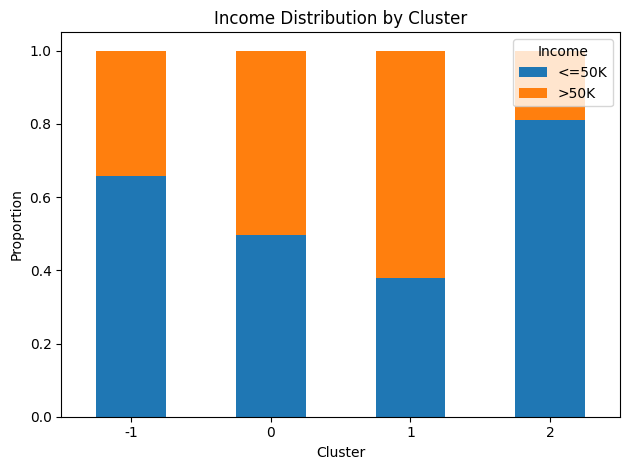


Detailed Cluster-Income Analysis:

Noise:
Total points: 167
Match with majority class: 0.0%

Cluster 0:
Total points: 2232
Match with majority class: 49.5%

Cluster 1:
Total points: 3940
Match with majority class: 62.1%

Cluster 2:
Total points: 42503
Match with majority class: 0.0%


In [ ]:
def analyze_income_distribution(df, cluster_labels, income_labels):
    df_analysis = pd.DataFrame({
        'Cluster': cluster_labels,
        'Income': income_labels
    })
    
    # Overall cluster composition
    print("Cluster Income Distribution:")
    for cluster in sorted(set(cluster_labels)):
        cluster_mask = df_analysis['Cluster'] == cluster
        cluster_size = cluster_mask.sum()
        
        # Get income distribution for this cluster
        income_dist = df_analysis[cluster_mask]['Income'].value_counts(normalize=True)
        income_counts = df_analysis[cluster_mask]['Income'].value_counts()
        
        cluster_name = "Noise" if cluster == -1 else f"Cluster {cluster}"
        print(f"\n{cluster_name} (Size: {cluster_size})")
        print(f"<=50K: {income_counts.get(0, 0)} ({income_dist.get(0, 0)*100:.1f}%)")
        print(f">50K: {income_counts.get(1, 0)} ({income_dist.get(1, 0)*100:.1f}%)")
        
        if cluster != -1:  # Skip noise points
            correlation = np.corrcoef(cluster_mask, income_labels)[0,1]
            print(f"Correlation with income: {correlation:.3f}")

def plot_income_distribution(cluster_labels, income_labels):
    """
    Visualize income distribution across clusters
    """
    # Create stacked bar chart
    df_plot = pd.DataFrame({
        'Cluster': cluster_labels,
        'Income': ['<=50K' if x == 0 else '>50K' for x in income_labels]
    })
    
    plt.figure(figsize=(10, 6))
    cluster_income = pd.crosstab(df_plot['Cluster'], df_plot['Income'], normalize='index')
    cluster_income.plot(kind='bar', stacked=True)
    plt.title('Income Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.legend(title='Income')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def analyze_income_patterns(df, cluster_labels, income_labels):
    print("="*50)
    print("Income Distribution Analysis")
    print("="*50)
    
    # Basic distribution analysis
    analyze_income_distribution(df, cluster_labels, income_labels)
    
    # Visualization
    plot_income_distribution(cluster_labels, income_labels)
    
    # Performance metrics
analyze_income_patterns(df_transformed, cluster_labels, true_labels)

Computing PCA projection...
Computing UMAP projection...


/home/andrea-gariboldi/Master/Year1/Semester1/AppliedMachineLearning/ICS5110-Applied_ML/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Computing t-SNE projection...


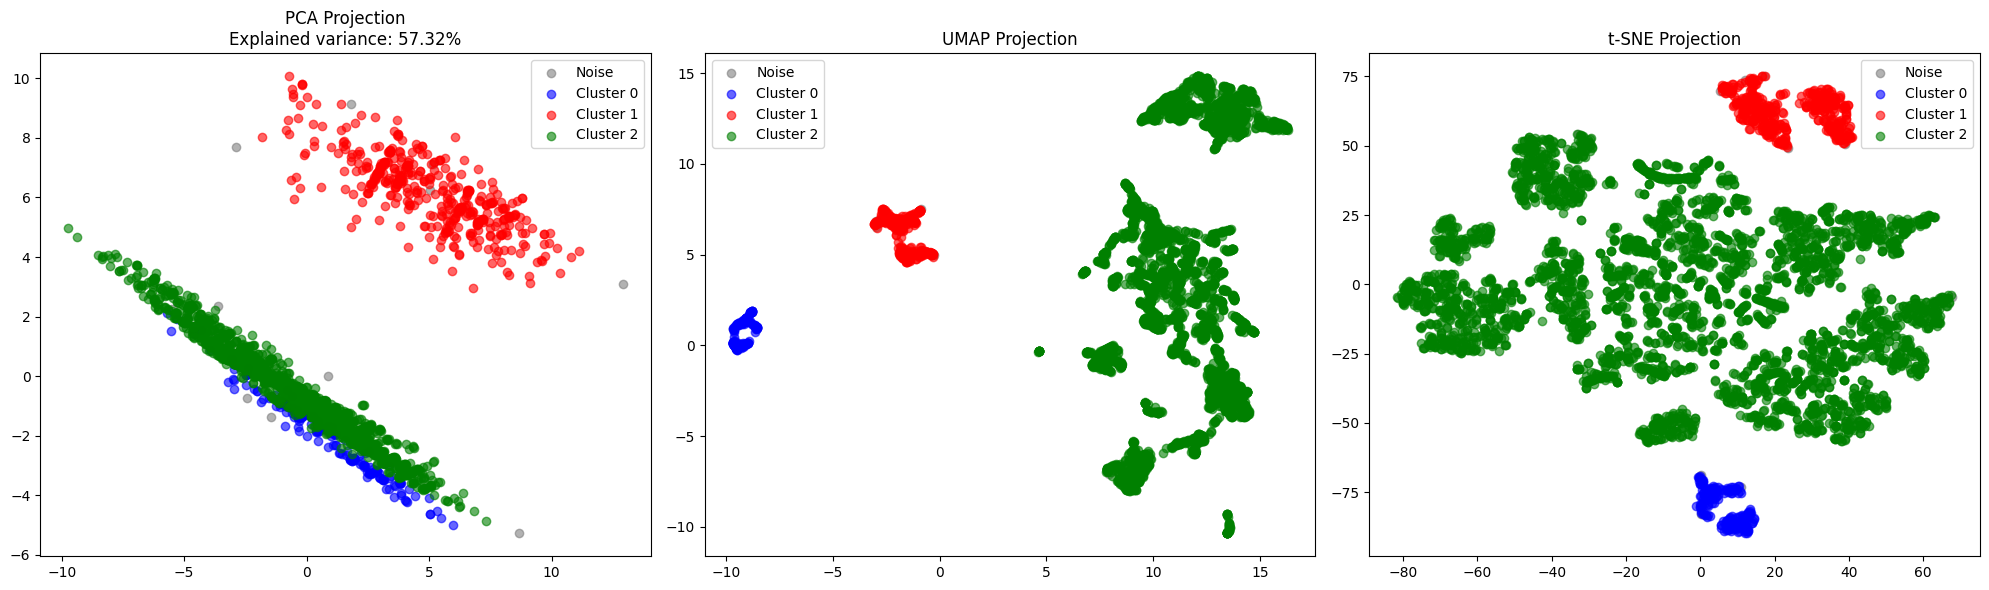


PCA Explained Variance Ratios:
PC1: 33.24%
PC2: 24.08%
Total: 57.32%

Cluster Sizes in Sample:
Noise: 13 points (0.3%)
Cluster 0: 205 points (4.1%)
Cluster 1: 434 points (8.7%)
Cluster 2: 4348 points (87.0%)


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

def visualize_clusters_clear_colors(df_transformed, cluster_labels, sample_size=5000, random_state=42):
    """
    Create visualizations with clear color distinction between clusters
    """
    # Sample the data
    if len(df_transformed) > sample_size:
        idx = np.random.RandomState(random_state).choice(
            len(df_transformed), sample_size, replace=False
        )
        df_sample = df_transformed.iloc[idx]
        clusters_sample = cluster_labels[idx]
    else:
        df_sample = df_transformed
        clusters_sample = cluster_labels
    
    # Create custom color map for better visibility
    cluster_colors = {
        -1: 'gray',    # Noise points in gray
        0: 'blue',     # Cluster 0 in blue
        1: 'red', 
        2: 'green'       # Cluster 1 in red
    }
    
    # Convert cluster labels to colors
    colors = [cluster_colors[label] for label in clusters_sample]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 6))
    
    # 1. PCA
    print("Computing PCA projection...")
    pca = PCA(n_components=2, random_state=random_state)
    embedding_pca = pca.fit_transform(df_sample)
    
    ax1 = fig.add_subplot(131)
    for cluster in [-1, 0, 1, 2]:
        mask = clusters_sample == cluster
        label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
        ax1.scatter(embedding_pca[mask, 0], embedding_pca[mask, 1], 
                   c=cluster_colors[cluster], 
                   alpha=0.6,
                   label=label)
    ax1.set_title(f'PCA Projection\nExplained variance: {pca.explained_variance_ratio_.sum():.2%}')
    ax1.legend()
    
    # 2. UMAP
    print("Computing UMAP projection...")
    reducer = umap.UMAP(random_state=random_state)
    embedding_umap = reducer.fit_transform(df_sample)
    
    ax2 = fig.add_subplot(132)
    for cluster in [-1, 0, 1, 2]:
        mask = clusters_sample == cluster
        label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
        ax2.scatter(embedding_umap[mask, 0], embedding_umap[mask, 1], 
                   c=cluster_colors[cluster], 
                   alpha=0.6,
                   label=label)
    ax2.set_title('UMAP Projection')
    ax2.legend()
    
    # 3. t-SNE
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, random_state=random_state)
    embedding_tsne = tsne.fit_transform(df_sample)
    
    ax3 = fig.add_subplot(133)
    for cluster in [-1, 0, 1, 2]:
        mask = clusters_sample == cluster
        label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
        ax3.scatter(embedding_tsne[mask, 0], embedding_tsne[mask, 1], 
                   c=cluster_colors[cluster], 
                   alpha=0.6,
                   label=label)
    ax3.set_title('t-SNE Projection')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print explained variance ratios for PCA
    print("\nPCA Explained Variance Ratios:")
    print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
    print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
    print(f"Total: {pca.explained_variance_ratio_.sum():.2%}")

    # Print cluster sizes
    unique, counts = np.unique(clusters_sample, return_counts=True)
    print("\nCluster Sizes in Sample:")
    for cluster, count in zip(unique, counts):
        label = 'Noise' if cluster == -1 else f'Cluster {cluster}'
        print(f"{label}: {count} points ({count/len(clusters_sample):.1%})")

# Usage:
visualize_clusters_clear_colors(df_transformed, cluster_labels)

**How, by changing a cost function, the demographics get affected?**

In [16]:
def analyze_demographic_impact(df, cluster_labels, demographic_column):
    """
    Analyze how clustering affects different demographic groups
    """
    impact_analysis = pd.DataFrame({
        'Cluster': cluster_labels,
        'Demographic': df[demographic_column]
    })
    
    # Distribution of demographics across clusters
    cluster_demographics = pd.crosstab(
        impact_analysis['Cluster'], 
        impact_analysis['Demographic'],
        normalize='index'
    )
    
    # Noise point analysis by demographic
    noise_rates = impact_analysis[impact_analysis['Cluster'] == -1]['Demographic'].value_counts(normalize=True)
    
    return cluster_demographics, noise_rates

analyze_demographic_impact(df, cluster_labels, 'gender')

(Demographic         0         1
 Cluster                        
 -1           0.209581  0.790419
  0           0.243728  0.756272
  1           0.233756  0.766244
  2           0.345670  0.654330,
 Demographic
 1    0.790419
 0    0.209581
 Name: proportion, dtype: float64)

**Export the model**

Used later for visualization with Gradio

In [10]:
import joblib

joblib.dump(clusterer, 'hdbscan_model_2.joblib')


['hdbscan_model_2.joblib']

In [15]:
import pickle

filename = 'hdbscan_model.pkl'
pickle.dump(clusterer, open(filename, 'wb'))

In [14]:
loaded_model = joblib.load('hdbscan_model.joblib')